---
layout:     post
title:      "Supreme Gridlock"
date:       2017-04-23 12:00:00
author:     Andrew
header-img: img/posts/supreme_court_seats/bench.jpg
header-credit: https://unsplash.com/@willpat
tags:       programming riddler politics puzzles
---

Last week I won the FiveThityEight [Riddler](https://fivethirtyeight.com/features/how-many-bingo-cards-are-there-in-the-world/)!  (don't get too excited, the winner is randomly selected 😉)

![winner]({{ site.baseurl }}/img/posts/supreme_court_seats/classic_winner.png)

I don't share every riddler I work on, but this one is straightforward yet interesting, politically applicable, and was fun to work on.

Here is the riddle:
> Imagine that U.S. Supreme Court nominees are only confirmed if the same party holds the presidency and the Senate. What is the expected number of vacancies on the bench in the long run?    
You can assume the following:
* You start with an empty, nine-person bench.
* There are two parties, and each has a 50 percent chance of winning the presidency and a 50 percent chance of winning the Senate in each election.
* The outcomes of Senate elections and presidential elections are independent.
* The length of time for which a justice serves is uniformly distributed between zero and 40 years.

Additional clarifications I made:
* President elected every 4 years, Senate every 2 years.
* Judicial terms will be integers (whole years), and if a judge leaves on an election year, the subsequent government will nominate.


Note: I have omitted some of the code for brevity.  Full code [here](https://github.com/andrewzwicky/puzzles/tree/master/FiveThirtyEightRiddler/2017-04-14)

In [1]:
from enum import Enum
import itertools
import random
from collections import Counter
import numpy as np
from plotting import *
from multiprocessing import Pool
from tqdm import tqdm_notebook

%matplotlib inline

First we'll need a way to track which party the Senate & President are part of.  Let's create a `Party` [enumeration](https://en.wikipedia.org/wiki/Enumerated_type) for this purpose.  Enumerations allow us to assign names to the different parties instead of having to remember which party goes with which value.  For now, let's stick to the two major parties.

In [2]:
class Party(Enum):
    D = 1
    R = 2
    
color_trans = {Party.D:'blue', Party.R:'red'}

We'll also make a class to represent each justice.  When a new `Justice` is created for a party, they'll be given a term of somewhere between 0 and 40 years, uniformly distributed.

In [3]:
class Justice:
    
    def __init__(self, party):
        self.party = party
        self.term = random.randint(0,40)
        
        
    def __str__(self):
        return self.__repr__()
    
    def __repr__(self):
        return "{party}-{term}".format(party=self.party.name,term=self.term)

In [4]:
print(Justice(Party.D))
print(Justice(Party.R))

D-26
R-25


Our lass class is `Bench`.  This class will represent the bench that contains the `Justices` currently on the Supreme Court.  When the `Bench` is first formed, it will be empty.  We care about modifying the `Bench` in a few ways:

1. Filling all available seats with judges of a certain party (`fill_seats`).
2. Adding years to determine if judges have vacated their seats (`add_years`).
3. Getting the composition of the court at a particular year, used for displaying the data later (`breakdown`).

Empty seats in the court are represented by `None`, and judges are removed when they have <= `0` years left in their term.

In [5]:
class Bench:
    
    SIZE = 9
    
    def __init__(self):
        self.seats = [None] * self.SIZE
    
    def fill_seats(self, party):
        # loop through all seats
        for i in range(self.SIZE):
            if self.seats[i] is None:
                # if seat is empty, add new 
                # justice of the correct party
                self.seats[i] = Justice(party)
                
    def add_years(self, num_years):
        for i in range(self.SIZE):
            if self.seats[i] is not None:
                # for occupied seats, remove the given
                # number of years from their remaining
                # term.  If their term is less than 0
                # this means their seat should now
                # be empty again.
                self.seats[i].term -= num_years
                if self.seats[i].term <= 0:
                    self.seats[i] = None
    
    def breakdown(self):
        c = Counter([s.party.name if s is not None else "" for s in self.seats])

        return tuple(c[k] if k in c else 0 for k in [""] + [e.name for e in Party])
    
    def __repr__(self):
        return "\n".join(map(str,self.seats))

In [6]:
b = Bench()
b.fill_seats(Party.R)
b.add_years(10)
b.fill_seats(Party.D)
b.add_years(4)
print(b)
print(b.breakdown())

R-15
R-17
D-16
D-5
D-13
R-12
R-21
R-23
R-22
(0, 3, 6)


`simulate` is where the magic happens.  This simulation will loop through the years, first determining if any judges have left their position.  After that, it randomly picks the winning parties for elections.  At the end of the elections, if the government is aligned, empty seats on the bench should be filled by that party.

In [7]:
def simulate(years):
    president_party = None
    senate_party = None
    bench = Bench()
        
    for year in range(years+1):
        bench.add_years(1)
        
        if year % 2 == 0:
            senate_party = random.choice(list(Party))
        
        if year % 4 == 0:
            president_party = random.choice(list(Party))
        
        if president_party == senate_party:
            bench.fill_seats(president_party)
        
        yield year, bench.breakdown(), president_party, senate_party

`run_simulation` will execute the simulation for the supplied number of years, and post-process the data to return the following information:    
`years`: an array of all the years that were simulated.    
`bench_stacks`: the stacked bar graph data for the composition of the court at each year.    
`president_parties`: an array of the president's party at each year.    
`senate_parties`: an array of the senate's party at each year.    
`mean`: an array with the mean number of vacancies per year at that point in the life of the court.

In [8]:
def run_simulation(sim_years):
    years, benches, president_parties, senate_parties = zip(*list(simulate(sim_years)))
    bench_stacks = np.row_stack(zip(*benches))
    vacancies = bench_stacks[0]
    mean = np.cumsum(vacancies) / ([1] + list(years[1:]))
    return years, bench_stacks, president_parties, senate_parties, mean

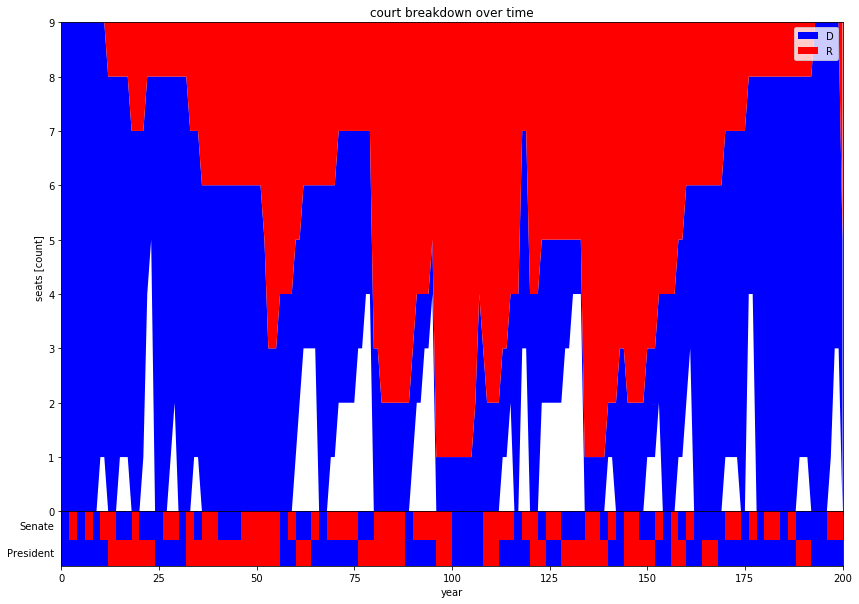

In [9]:
sim_years = 200

years, bench_stacks, president_parties, senate_parties, mean = run_simulation(sim_years)

stacked_plot_bench_over_time_with_parties(years,
                                          bench_stacks,
                                          president_parties,
                                          senate_parties,
                                          color_trans,
                                          Party)

This plot shows how the court functions over 200 years, including the respective party affiliations at any time.  In the periods of divided government, the vacancies get larger, and when the government is aligned, the court becomes full again (no surprise, that what it's supposed to do!).  However, the interesting thing is determining more precisely how many vacancies we can expect at any given time.

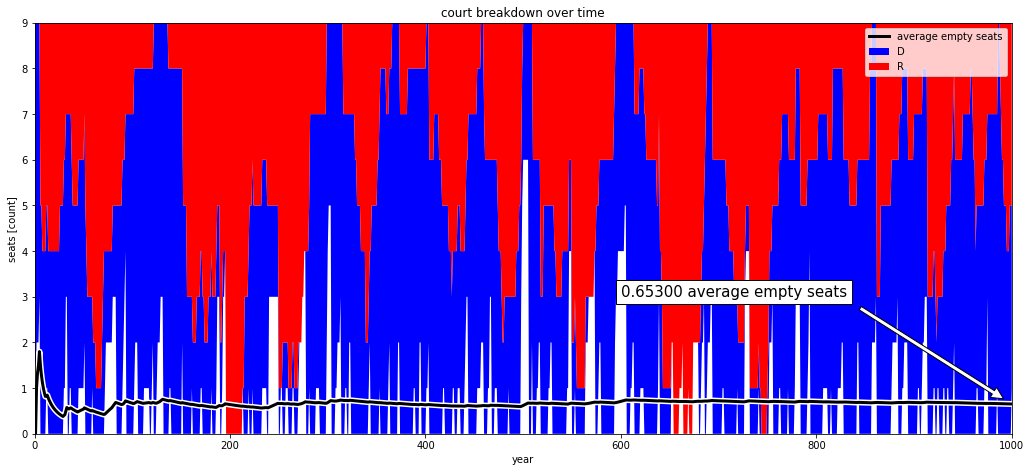

In [10]:
sim_years = 1000

years, bench_stacks, president_parties, senate_parties, mean = run_simulation(sim_years)

stacked_plot_bench_over_time(years, bench_stacks, mean, color_trans, Party)

In this plot, let's extend the timeline to 1000 years to give the average a longer time to settle.  This simulation shows that we should expect a little less than 1 vacancy per year.

However, this is only 1 simulation that includes randomness.  To give a better estimate of where this probability actually falls, let's run multiple simulations and examine the distribution of expected vacancies.

In [11]:
sim_years = 50000
sample_size = 500

results=[]

with Pool(processes=4) as p:
    with tqdm_notebook(total=sample_size) as pbar:
        for r in p.imap_unordered(run_simulation, itertools.repeat(sim_years,sample_size)):
            results.append(r)
            pbar.update(1)
    
years, _, _, _, means = zip(*results)

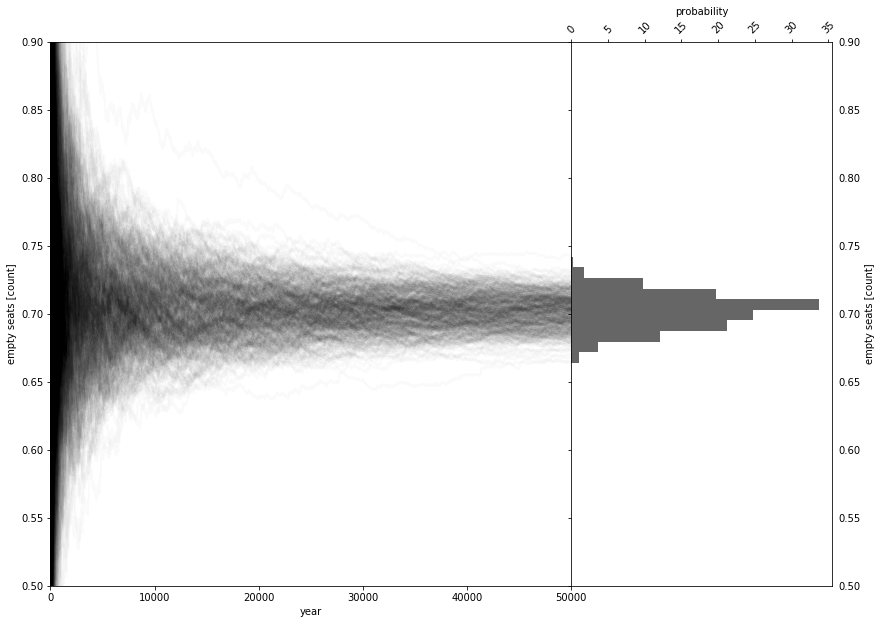

In [12]:
plot_sims(years[0], means, [0.5, 0.9])

Running the 50000 year simulation 500 times shows us the expected distribution and it would be more accurate to say that we should expect ~0.7 vacancies per year, instead of the singular value we received above.

### Get the Party started

As a thought experiment, let's see what happen if the Green Party suddenly launches into relevance and has an equal shot at all of our elections.  How would this impact the result?

In [13]:
class Party(Enum):
    D = 1
    R = 2
    G = 3
    
color_trans = {Party.D:'blue', Party.R:'red', Party.G:'green'}

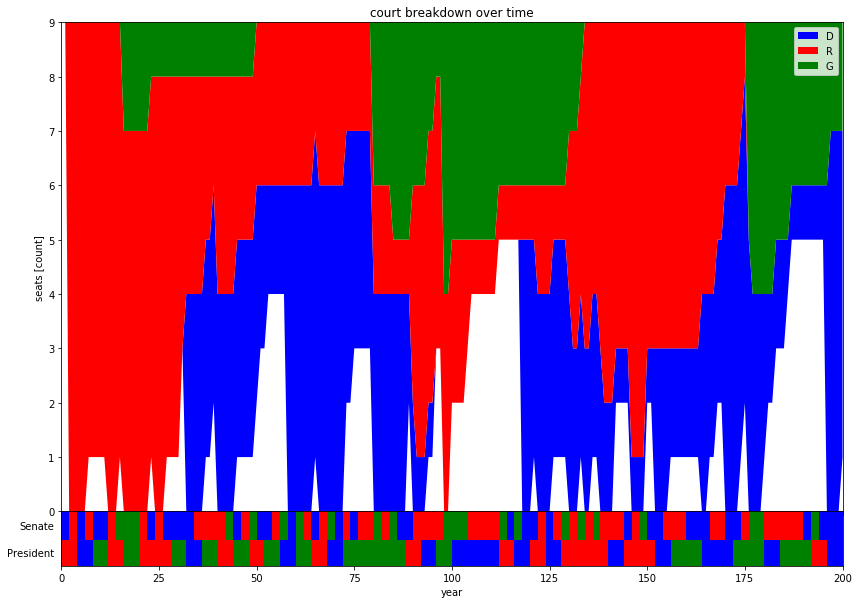

In [18]:
sim_years = 200

years, bench_stacks, president_parties, senate_parties, mean = run_simulation(sim_years)

stacked_plot_bench_over_time_with_parties(years,
                                          bench_stacks,
                                          president_parties,
                                          senate_parties,
                                          color_trans,
                                          Party)

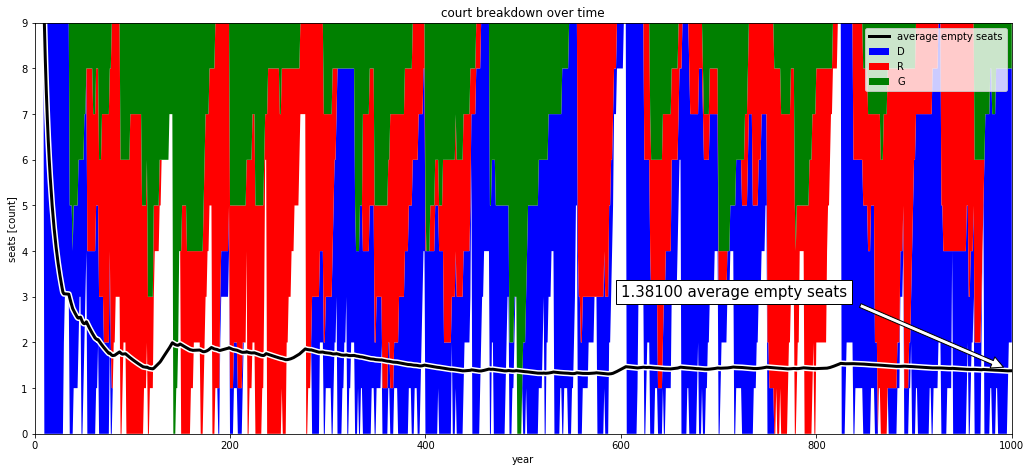

In [14]:
sim_years = 1000

years, bench_stacks, president_parties, senate_parties, mean = run_simulation(sim_years)

stacked_plot_bench_over_time(years, bench_stacks, mean, color_trans, Party)

Unsurprisingly, adding more parties into the mix while still requiring an aligned government looks like it leads to even more vacancies.

In [15]:
sim_years = 50000
sample_size = 500

results=[]

with Pool(processes=4) as p:
    with tqdm_notebook(total=sample_size) as pbar:
        for r in p.imap_unordered(run_simulation, itertools.repeat(sim_years,sample_size)):
            results.append(r)
            pbar.update(1)
    
years, _, _, _, means = zip(*results)

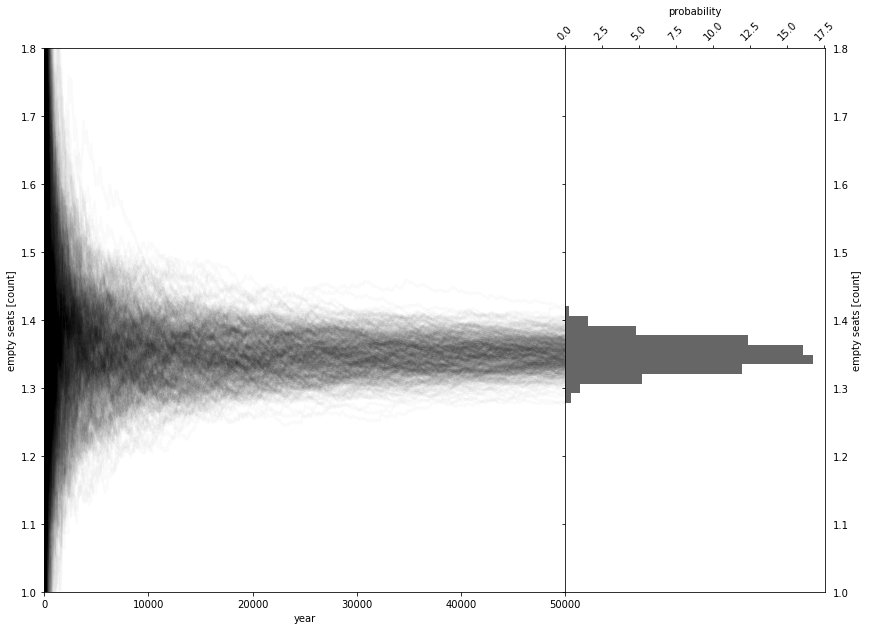

In [16]:
plot_sims(years[0], means, [1, 1.8])

## Related Reading
[https://hectorpefo.github.io/2017-04-16-supreme-vacancies/](https://hectorpefo.github.io/2017-04-16-supreme-vacancies/)    
[http://www.laurentlessard.com/bookproofs/a-supreme-court-puzzle/](http://www.laurentlessard.com/bookproofs/a-supreme-court-puzzle/)